# Imports and model setup

In [ ]:
import spacy
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from collections import defaultdict
!pip install rouge_score
from rouge_score import rouge_scorer
!pip install nltk
from nltk.translate.bleu_score import sentence_bleu
!pip install scientific_information_change
from scientific_information_change.estimate_similarity import SimilarityEstimator
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer, util
import re
!pip install openai
import openai
# Load ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
# Load IMS
estimator = SimilarityEstimator()
# Load model for language processing
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz
nlp = spacy.load('en_core_sci_sm')
# Load SBERT model
model = SentenceTransformer('nli-distilroberta-base-v2')


In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Functions

In [ ]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

device = "cuda"
model_id = "gpt2-large"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

In [ ]:
from datasets import load_dataset

test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
test['text']

In [ ]:
def calculate_metrics(predictions):
    # Initialize counters for each class
    class_counts = {'SUPPORTS': {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0},
                    'CONTRADICTS': {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0},
                    'UNRELATED': {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}}

    # Iterate through the predictions
    for actual, predicted in predictions:
        for cls in class_counts.keys():
            if actual == predicted == cls:
                class_counts[cls]['tp'] += 1
            elif actual == predicted != cls:
                class_counts[cls]['tn'] += 1
            elif actual == cls and predicted != cls:
                class_counts[cls]['fn'] += 1
            elif actual != cls and predicted == cls:
                class_counts[cls]['fp'] += 1

    # Calculate precision, recall, and accuracy for each class
    metrics_per_class = {}
    confusion_matrices = {}

    for cls, counts in class_counts.items():
        precision = counts['tp'] / (counts['tp'] + counts['fp']) if (counts['tp'] + counts['fp']) > 0 else 0
        recall = counts['tp'] / (counts['tp'] + counts['fn']) if (counts['tp'] + counts['fn']) > 0 else 0
        accuracy = (counts['tp'] + counts['tn']) / sum(counts.values())

        metrics_per_class[cls] = {'precision': precision, 'recall': recall, 'accuracy': accuracy}

        # Confusion matrix
        confusion_matrix = np.array([[counts['tp'], counts['fp']], [counts['fn'], counts['tn']]])
        confusion_matrices[cls] = confusion_matrix

    return metrics_per_class, confusion_matrices

def big_one(predictions):
    classes = ['SUPPORTS', 'CONTRADICTS', 'UNRELATED']

    # Create a mapping dictionary
    class_mapping = {label: idx for idx, label in enumerate(classes)}

    # Convert actual and predicted values to numeric
    actual_values = [class_mapping[item[0]] for item in predictions]
    predicted_values = [class_mapping[item[1]] for item in predictions]

    # Compute micro F1 score
    micro_f1 = f1_score(actual_values, predicted_values, average='micro')
    print(f'Micro F1 Score: {micro_f1:.4f}')

    # Compute macro F1 score
    macro_f1 = f1_score(actual_values, predicted_values, average='macro')
    print(f'Macro F1 Score: {macro_f1:.4f}')

    # Compute confusion matrix
    conf_matrix = confusion_matrix(actual_values, predicted_values, labels=np.arange(len(classes)))

    # Display confusion matrix
    print(conf_matrix)

    # Display confusion matrix with labels
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



In [ ]:
# Score the similarity of two strings given a scoring method
def similarity(scoring_type, str1, str2):
    scoring_type = scoring_type.lower()
    if (scoring_type == 'rouge'):  # 0-1
        scores = scorer.score(str1, str2)
        avg_score = (scores['rouge1'][2] + scores['rouge2'][2] + scores['rougeL'][2]) / 3
        return avg_score
    elif (scoring_type == 'bleu'):  # 0-1
        return sentence_bleu(str1.split(), str2.split(), weights=(0.25, 0.25, 0.25, 0.25))
    elif (scoring_type == 'ims' or scoring_type == 'information matching score'):  # 0-5, normalized to 0-1
        return estimator.estimate_ims_array([str1], [str2]) / 5
    elif (scoring_type == 'sbert'):  # 0-1
        embeddings1 = model.encode([str1], convert_to_tensor=True)
        embeddings2 = model.encode([str2], convert_to_tensor=True)
        return util.cos_sim(embeddings1, embeddings2).item()
    else:
        raise Exception("Please provide valid scoring_type")

In [ ]:
def claim_to_evidence(scoring_type):
    # ssum = 0
    # csum = 0
    # savg = 0
    # cavg = 0
    results = []
    for i in range(len(claim_id_to_claim)):
        claim = claim_id_to_claim[i]
        for doc_id in claim['evidence']:
            for sentences in claim['evidence'][doc_id]:
                evidence = ""
                for sentence_number in sentences['sentences']:
                    evidence += corpus[int(doc_id)]['abstract'][sentence_number] + " "
                # Conduct similarity assessment
                score = similarity(scoring_type, claim['claim'], evidence)
                # Store results
                results.append((score, sentences['label'], claim, evidence, doc_id))
                # Update stats
                # if (sentences['label'] == 'SUPPORT'):
                #     savg += score
                #     ssum += 1
                # elif (sentences['label'] == 'CONTRADICT'):
                #     csum += 1
                #     cavg += score
    # cavg /= csum
    # savg /= ssum
    # print(ssum)
    # print(csum)
    # print(savg)
    # print(cavg)
    return results

In [ ]:
def citance_to_evidence(scoring_type):
    scores = []
    failed_keys = []
    # Loop through citances dict
    for citance in citances:
        citance_scores = []
        # For each citance, loop through all claims
        for claim in citance[1]:
            if claim['is_negation']:
                continue
            claim['normalized'] = re.sub(r'[.!?,\s]', '', claim['text'].lower())
            # For each associated claim, loop through all associated evidence
            if claim['normalized'] not in claims_and_evidence:
                failed_keys.append(claim['normalized'])
                continue
            for doc_id in claims_and_evidence[claim['normalized']]:
                for sentences in claims_and_evidence[claim['normalized']][doc_id]:
                    evidence = ""
                    for sentence_number in sentences['sentences']:
                        evidence += corpus[int(doc_id)]['abstract'][sentence_number] + " "
                    # Score evidence to citance
                    citance_scores.append(similarity(scoring_type, citance[0], evidence))
        # Assign citance to dict: [max, mean] scores
        if len(citance_scores) > 0:
            scores.append((citance[0], max(citance_scores), sum(citance_scores) / len(citance_scores)))
    total = len(failed_keys) + len(scores)
    # print("Total:", total) Failure rate
    # print("Failure rate:", len(failed_keys) / total)
    # print("Failed total: ", len(failed_keys))
    # print("Success total:", len(scores))
    return scores

In [ ]:
def hist_and_box_plot(scoring_type):
    scores = citance_to_evidence(scoring_type)
    avg_scores = [x[2] for x in scores]
    print(scoring_type + " for citance to evidence:")
    print("Average of average:", sum(avg_scores) / len(scores))
    print("Average of max:    ", sum([x[1] for x in scores]) / len(scores))
    print("Max of max:        ", max([x[1] for x in scores]))
    print("Q1 quantile: ", np.quantile(avg_scores, .25))
    print("Q2 quantile: ", np.quantile(avg_scores, .50))
    print("Q3 quantile: ", np.quantile(avg_scores, .75))
    print("Q4 quantile: ", np.quantile(avg_scores, 1))
    fig, axs = plt.subplots(4, figsize=(10, 15))
    fig.tight_layout(pad=5.0)
    axs[0].hist(avg_scores, bins=20)
    axs[0].set_ylabel('Count')
    axs[0].set_xlabel(scoring_type + ' Score')
    axs[0].set_title("Citance to Evidence", fontsize=20)
    axs[1].boxplot((avg_scores), vert=False)
    axs[1].set_xlabel(scoring_type + ' Score')
    scores = claim_to_evidence(scoring_type)
    avg_scores = [x[0] for x in scores]
    print(scoring_type + " for claim to evidence:")
    print("Average of average:", sum(avg_scores) / len(scores))
    print("Q1 quantile: ", np.quantile(avg_scores, .25))
    print("Q2 quantile: ", np.quantile(avg_scores, .50))
    print("Q3 quantile: ", np.quantile(avg_scores, .75))
    print("Q4 quantile: ", np.quantile(avg_scores, 1))
    axs[2].hist(avg_scores, bins=20)
    axs[2].set_ylabel('Count')
    axs[2].set_xlabel(scoring_type + ' Score')
    axs[2].set_title("Claim to Evidence", fontsize=20)
    axs[3].boxplot((avg_scores), vert=False)
    axs[3].set_xlabel(scoring_type + ' Score')
    plt.show()

# Data prep

In [ ]:
!pip install openai==0.28
import openai
import json
import re

In [ ]:
# create a lookup for the pdf parse based on paper ID
corpus = {}
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/scifact_dataset/corpus.jsonl') as f_pdf:
    for line in f_pdf:
        pdf_parse_dict = json.loads(line)
        corpus[pdf_parse_dict['doc_id']] = pdf_parse_dict
print("Corpus parsed.")

Corpus parsed.


In [ ]:
claim_id_to_claim = []
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/scifact_dataset/claims_train.jsonl') as f_pdf:
    for line in f_pdf:
        claim_dict = json.loads(line)
        if (claim_dict['evidence']):
          claim_id_to_claim.append(claim_dict)
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/scifact_dataset/claims_dev.jsonl') as f_pdf:
    for line in f_pdf:
        claim_dict = json.loads(line)
        if (claim_dict['evidence']):
          claim_id_to_claim.append(claim_dict)
print("Claims parsed.")
print(len(claim_id_to_claim))

Claims parsed.
693


In [ ]:
# create a lookup for the pdf parse based on paper ID
citances = []
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/scifact_dataset/claims_with_citances.jsonl') as f_pdf:
    for line in f_pdf:
        citance_dict = json.loads(line)
        citances.append((re.sub(r' \[\d+\]', '', citance_dict['citance']), citance_dict['claims']))
        # citances.append((citance_dict['citance'], citance_dict['claims']))
print("Citances parsed.")

Citances parsed.


In [ ]:
claims_and_evidence = {}
for i in claim_id_to_claim:
    i['normalized_claim'] = re.sub(r'[.!?,\s]', '', i['claim'].lower())
    claims_and_evidence[i['normalized_claim']] = i['evidence']

# OpenAI nonsense

In [ ]:
prompts = ["Please negate this sentence by changing as few words as possible in the original sentence: "]
          #  "Please provide two different examples of a negated version of the following sentence, by changing as few words as possible in the original sentence: ",
          #  "A negated sentence is a sentence that has had one or more words added, removed, or changed so that the resulting sentence has the opposite meaning from the original. Here are two examples: \n\tOriginal sentence: Biodegradable and biocompatible 0DBMs seem to be promising candidates to solve the problem, since they show great abilities to deliver the biomolecules in to cells, and some 0DBMs even show inductive properties themselves. \n\tNegated sentence: Biodegradable and biocompatible 0DBMs do not seem to be promising candidates to solve the problem, since they show limited abilities to deliver the biomolecules in to cells, and some 0DBMs even lack inductive properties themselves. \n\tOriginal sentence: Approximately 90% of SIDS deaths occur in infants aged less than 6 months. \n\tNegated sentence: Approximately 10% of SIDS deaths occur in infants aged less than 6 months. \n\tPlease provide a negated version of the following sentence: ",
          #  "Please provide a new sentence with the opposite meaning as the following, by changing as few words as possible in the original: ",
          #  "Please provide a new sentence with the opposite meaning as the following, by changing a small number of words: ",
          #  "Please provide a new sentence with the opposite meaning as the following: "]
negations = []
# Loop through all citances
for citance in citances[:20]:
  citance = citance[0]
  print(citance)
  # Use current citance as a variable in the standard prompt
  for prompt in prompts:
    response = openai.Completion.create(model="text-davinci-003", prompt=prompt + citance, temperature=0, max_tokens=256)
    negations.append((citance, prompt, response))
  # Add the result to an array
  # negations.append((citance, response))

Active caspase-11 then promotes pyroptosis, and could also participate in the activation of the NLRP3 inflammasome or regulate phagosome-lysosome fusion .


InvalidRequestError: The model `text-davinci-003` has been deprecated, learn more here: https://platform.openai.com/docs/deprecations

In [ ]:
for i in range(20):
  print("\n"  + str(i) + " Citance:", negations[i * len(prompts)][0])
  for j in range(len(prompts)):
    # print("\n\tPrompt:  ", negations[i * 4 + j][1])
    print(str(j) + "Response:", negations[i * len(prompts) + j][2].choices[0].text[2:])

0. TRUE
> Clause 1 negated, 2 negated
1. TRUE
> Clause 1 negated, 2 failed, 3 failed. Main idea changed
2. TRUE
3. TRUE
> Clause 1 negated, 2 unchanged. Main idea negated
4. FALSE
> Lost clause 1, negated clause 2
5. TRUE
6. FALSE
> Lost clause 1, negated clause 2
7. TRUE
8. TRUE
9. FALSE
> Neutral instead of negated
10. FALSE
> Neutral instead of negated
11. TRUE
> it's close tho lol
12. TRUE
13. N/A
> Error in citance
14. FALSE
> Neutral instead of negated
15. TRUE
16. TRUE
> suspect. curious. fishy. 🐠
17. TRUE
> Sentence is weird lol
18. TRUE
> Carlos and I disagree about info retention :(
19. TRUE
> Sentence structure flipped, tokens retained

15 / 19 (one N/A)
18 / 19 if neutral = true

In [ ]:
negations = {}
failures = 0
successes = 0
# Loop through all citances
for citance in citances[:20]:
  time.sleep(5.5)
  citance = citance[0]
  # Use current citance as a variable in the standard prompt
  # response = openai.Completion.create(model="text-davinci-003", prompt=prompt + citance, temperature=0, max_tokens=256)
  # response = response.choices[0].text[2:]
  message = [{"role": "user", "content": prompt + citance}]
  response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0)
  response = response.choices[0].message.content
  rlen = len(response.split())
  clen = len(citance.split())
  # if (rlen > clen * 1.2 or rlen < clen * 0.8):
  #   failures += 1
  #   continue
  # else:
  #   negations[citance] = response
  #   successes += 1
  negations[citance] = response
print("Successes:", successes)
print("Failures: ", failures)
print(negations)

In [ ]:
len(negations)

# NEGATION PROMPT TESTING

In [ ]:
prompts = ["Please negate this sentence by changing as few words as possible in the original sentence: ",
           "Please provide two different examples of a negated version of the following sentence, by changing as few words as possible in the original sentence: ",
           "A negated sentence is a sentence that has had one or more words added, removed, or changed so that the resulting sentence has the opposite meaning from the original. Here are two examples: \n\tOriginal sentence: Biodegradable and biocompatible 0DBMs seem to be promising candidates to solve the problem, since they show great abilities to deliver the biomolecules in to cells, and some 0DBMs even show inductive properties themselves. \n\tNegated sentence: Biodegradable and biocompatible 0DBMs do not seem to be promising candidates to solve the problem, since they show limited abilities to deliver the biomolecules in to cells, and some 0DBMs even lack inductive properties themselves. \n\tOriginal sentence: Approximately 90% of SIDS deaths occur in infants aged less than 6 months. \n\tNegated sentence: Approximately 10% of SIDS deaths occur in infants aged less than 6 months. \n\tPlease provide a negated version of the following sentence: ",
           "Please provide a new sentence with the opposite meaning as the following, by changing as few words as possible in the original: ",
           "Please provide a new sentence with the opposite meaning as the following, by changing a small number of words: ",
           "Please provide a new sentence with the opposite meaning as the following: "]
negations = []
# Loop through all citances
for citance in citances[:2]:
  citance = citance[0]
  print(citance)
  # Use current citance as a variable in the standard prompt
  for prompt in prompts:
    response = openai.Completion.create(model="gpt-3.5-turbo-instruct", prompt=prompt + citance, temperature=0, max_tokens=256)
    negations.append((citance, prompt, response))
  # Add the result to an array
  # negations.append((citance, response))

Active caspase-11 then promotes pyroptosis, and could also participate in the activation of the NLRP3 inflammasome or regulate phagosome-lysosome fusion .
Biodegradable and biocompatible 0DBMs seem to be promising candidates to solve the problem, since they show great abilities to deliver the biomolecules in to cells , and some 0DBMs even show inductive properties themselves.


In [ ]:
# for i in range(len(negations)):
#   print("\n"  + str(i) + " Citance:", negations[i * len(prompts)][0])
#   for j in range(len(prompts)):
#     # print("\n\tPrompt:  ", negations[i * 4 + j][1])
#     print(str(j) + "Response:", negations[i * len(prompts) + j][2].choices[0].text[2:])

for item in negations:
    print("Prompt:", item[1])
    print("Citance:", item[0])
    print("Response:", item[2].choices[0].text[2:])
    print('\n\n\n')


Prompt: Please negate this sentence by changing as few words as possible in the original sentence: 
Citance: Active caspase-11 then promotes pyroptosis, and could also participate in the activation of the NLRP3 inflammasome or regulate phagosome-lysosome fusion .
Response: Inactive caspase-11 then inhibits pyroptosis, and could also hinder the activation of the NLRP3 inflammasome or disrupt phagosome-lysosome fusion.




Prompt: Please provide two different examples of a negated version of the following sentence, by changing as few words as possible in the original sentence: 
Citance: Active caspase-11 then promotes pyroptosis, and could also participate in the activation of the NLRP3 inflammasome or regulate phagosome-lysosome fusion .
Response: 1. Inactive caspase-11 does not promote pyroptosis, and does not participate in the activation of the NLRP3 inflammasome or regulate phagosome-lysosome fusion.
2. Caspase-11 does not actively promote pyroptosis, and does not play a role in the

# GPT-4 negation verification

In [ ]:
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/negations.json') as f:
    negations = json.load(f)

FileNotFoundError: ignored

In [ ]:
# query = "Given two sentences, please evaluate the extent to which the second sentence is a negation of the first. Please provide a score in the domain [0, 100], where a score of 0 means identical meaning and a score of 100 means a perfect negation. \nFirst sentence: {} \nSecond sentence {}"
query = "Given two sentences, please evaluate the extent to which the second sentence is a negation of the first. Please provide a confidence score in the domain [0, 100], where a score of 0 means identical meaning and a score of 100 means a perfect negation. \nFirst sentence: {} \nSecond sentence {}"
results = []
# i = 0
for key in negations:
  time.sleep(1)
  # i += 1
  prompt = query.format(key, negations[key])
  message = [{"role": "user", "content": prompt}]
  try:
    response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
  except:
    print('L + ratio')
    continue
  score = response.choices[0].message.content
  results.append((key, negations[key], score))
  # if i == 20:
  #   break

# for result in results:
#   if int(result[2]) < 70:
#     print("Score:", result[2])
#     print(result[0])
#     print(result[1])
#     print()

In [ ]:
negation_score_dict = {}
for item in results:
  negation_score_dict[item[0]] = [item[1], item[2]]

obj = json.dumps(negation_score_dict, indent=4)

# Write line to file
with open('/content/gdrive/MyDrive/Independent study - Max & Carlos/data/negations_with_scores_gpt4.json', 'w') as f:
  f.write(obj)

In [ ]:
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/negations_with_scores_gpt4.json') as f:
    items = json.load(f)
negation_to_claim = {}
results = []
for k in items:
  results.append((k, items[k][0], items[k][1]))
  negation_to_claim[items[k][0]] = k

In [ ]:
obj = json.dumps(negations, indent=4)

# Write line to file
with open('/content/gdrive/MyDrive/Independent study - Max & Carlos/data/negations_gpt4.json', 'w') as f:
  f.write(obj)

In [ ]:
negations_set = set() ## negation dictionary for processing
for result in results:
  if len(result[2]) < 4 and int(result[2]) >= 90:
    negations_set.add(result[1])

In [ ]:
scores = []
low_scores = []
for result in results:
    scores.append(int(result[2]))
    if int(result[2]) < 70:
        low_scores.append(int(result[2]))

Total scores: 566
Low scores: 30
First Quartile: 95.0
Median (Second Quartile): 100.0
Third Quartile: 100.0


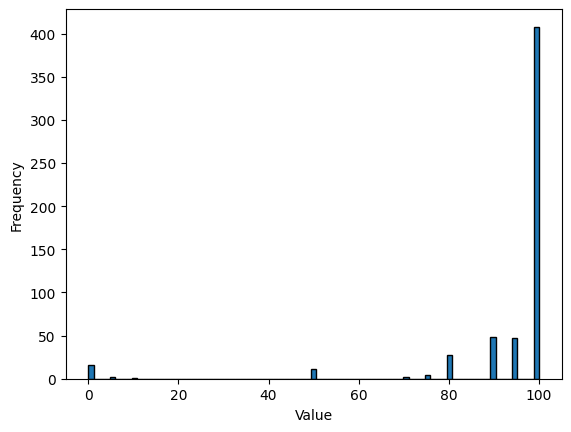

In [ ]:
np.mean(scores)
first_quartile = np.percentile(scores, 25)
median = np.percentile(scores, 50)
third_quartile = np.percentile(scores, 75)
print("Total scores:", len(scores))
print("Low scores:", len(low_scores))
print("First Quartile:", first_quartile)
print("Median (Second Quartile):", median)
print("Third Quartile:", third_quartile)

plt.hist(scores, bins='auto', edgecolor='black')  # 'auto' selects the number of bins automatically
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [ ]:
high_scores = []
for result in results:
  if int(result[2]) >= 90:
    high_scores.append(result[2])
    # print("Score:", result[2])
    # print(result[0])
    # print(result[1])
    # print()
print(len(high_scores))
print(len([i for i in results if int(i[2]) > 90]))

503
455


# GPT-4 claim verification

In [ ]:
# Prepare the dataset to iterate through

counter = 0
corpus = {}
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/corpus.jsonl') as f_pdf:
    for line in f_pdf:
        pdf_parse_dict = json.loads(line)
        corpus[pdf_parse_dict['doc_id']] = pdf_parse_dict
print("Corpus parsed.")

nei = 'UNRELATED' # TODO: THIS MIGHT NEED TO BE CHANGED

# Prepare the dataset to iterate through
train = {}
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/train.jsonl') as f_pdf:
    for line in f_pdf:
        parse = json.loads(line)
        for i in range(len(parse['doc_ids'])):
          if i == 0:
            temp = {
                'claim': parse['claim'],
                'label': parse['evidence'][str(parse['doc_ids'][i])][0]['label'] + 'S'
            }
            train[parse['doc_ids'][i]] = temp
          else:
            temp = {
                'claim': parse['claim'],
                'label': nei
            }
            train[parse['doc_ids'][i]] = temp
print("Train parsed.")

test = []
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/data/dev.jsonl') as f_pdf:
    for line in f_pdf:
        parse = json.loads(line)
        for i in range(len(parse['doc_ids'])):
          if i == 0:
            if parse['evidence'][str(parse['doc_ids'][i])][0]['label'] + 'S' == "CONTRADICTS" and parse['claim'] not in negations_set: ## negation checker
              counter += 1
              continue
            temp = {
                'claim': parse['claim'],
                'label': parse['evidence'][str(parse['doc_ids'][i])][0]['label'] + 'S',
                'id': parse['doc_ids'][i]
            }
          else:
            temp = {
                'claim': parse['claim'],
                'label': nei,
                'id': parse['doc_ids'][i]
            }
          test.append(temp)
print("Dev parsed.")
print(str(counter + 1), "negations removed.")

train_supports = {}
train_contradicts = {}
train_nei = {}
for key in train.keys():
  if train[key]['label'] == 'SUPPORTS':
    train_supports[key] = train[key]
  if train[key]['label'] == 'CONTRADICTS':
    train_contradicts[key] = train[key]
  if train[key]['label'] == nei:
    train_nei[key] = train[key]

Corpus parsed.
Train parsed.
Dev parsed.
4 negations removed.


In [ ]:
random.seed(22)

# p = "The following is an example of a claim and an abstract, where the abstract {} the claim. \nExample claim: {} \nExample abstract: {} \nGiven the following new abstract and claim, please state whether the abstract SUPPORTS, CONTRADICTS, or IS UNRELATED TO the claim. Please use respond using only the capitalized word(s) to provide a response. \nClaim: {} \nAbstract: {}"]
intro = "The following are examples of claims from a research paper and the corresponding abstract from the paper they are citing."
supports =  "\nThis is an example of an abstract that SUPPORTS the claim: \n\tSuppporting abstract: {} \n\tClaim: {}"
contradicts = "\nThis is an example of an abstract that CONTRADICTS the claim: \n\tContradicting abstract: {} \n\tClaim: {}"
unrelated = "\nThis is an example of an abstract that is UNRELATED to the claim: \n\tUnrelated abstract: {} \n\tClaim: {}"
query = "\nGiven a new abstract and claim pair, determine whether the abstract SUPPORTS, CONTRADICTS, or is UNRELATED to the claim. Please return your answer using only the single capitalized word. \n\tNew abstract: {} \n\tClaim: {}"

results = []
fails = []
match_count = 0
miss_count = 0
misses = []

for item in test:
  time.sleep(5.5)
  key = item['id']
  abstract = corpus[key]['abstract']
  claim = item['claim']
  label = item['label']
  query_string = query.format(abstract, claim)

  k, v = random.choice(list(train_supports.items()))
  supports_claim = v['claim']
  supports_abstract = corpus[k]['abstract']
  supports_string = supports.format(supports_abstract, supports_claim)

  k, v = random.choice(list(train_contradicts.items()))
  contradicts_claim = v['claim']
  contradicts_abstract = corpus[k]['abstract']
  contradicts_string = contradicts.format(contradicts_abstract, contradicts_claim)

  k, v = random.choice(list(train_nei.items()))
  nei_claim = v['claim']
  nei_abstract = corpus[k]['abstract']
  unrelated_string = unrelated.format(nei_abstract, nei_claim)

  temp = [supports_string, contradicts_string, unrelated_string]
  random.shuffle(temp)
  prompt = intro + temp[0] + temp[1] + temp[2] + query_string
  message = [{"role": "user", "content": prompt}]
  try:
    response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
  except Exception as e:
    print('sad')
    print(e)
    continue

  predicted = response.choices[0].message.content
  results.append((label, predicted))

  if predicted != 'SUPPORTS' and predicted != 'CONTRADICTS' and predicted != 'UNRELATED':
    fails.append(results[-1])
  else:
    if predicted == label:
      match_count += 1
    elif predicted == "SUPPORTS" and label == "CONTRADICTS":
      print(claim)
      print(negation_to_claim[claim])
      print()
    else:
      miss_count += 1
      misses.append((claim, abstract, label, predicted))

sad
You exceeded your current quota, please check your plan and billing details.


KeyboardInterrupt: ignored

Total:   112
Matches: 97
Misses:  7
Match rate: 0.9326923076923077
Micro F1 Score: 0.8661
Macro F1 Score: 0.8627
[[36  0  1]
 [ 8 25  2]
 [ 3  1 36]]


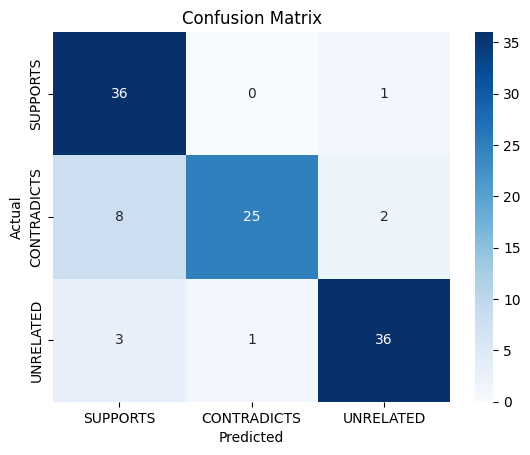

Class: SUPPORTS
Precision: 0.77
Recall: 0.97
Accuracy: 0.89
Confusion Matrix:
[[36 11]
 [ 1 61]]

Class: CONTRADICTS
Precision: 0.96
Recall: 0.71
Accuracy: 0.90
Confusion Matrix:
[[25  1]
 [10 72]]

Class: UNRELATED
Precision: 0.92
Recall: 0.90
Accuracy: 0.93
Confusion Matrix:
[[36  3]
 [ 4 61]]



In [ ]:
print("Total:  ", len(results))
print("Matches:", match_count)
print("Misses: ", miss_count)
print("Match rate:", match_count / (match_count + miss_count))
big_one(results)
# print(misses)
# print(fails)
class_metrics, confusion_matrices = calculate_metrics(results)
for cls, metrics in class_metrics.items():
    print(f'Class: {cls}')
    print(f'Precision: {metrics["precision"]:.2f}')
    print(f'Recall: {metrics["recall"]:.2f}')
    print(f'Accuracy: {metrics["accuracy"]:.2f}')
    print('Confusion Matrix:')
    print(confusion_matrices[cls])
    print()


Total:   115
Matches: 94
Misses:  21
Match rate: 0.8173913043478261
Micro F1 Score: 0.8174
Macro F1 Score: 0.8172
[[35  1  1]
 [11 26  1]
 [ 5  2 33]]


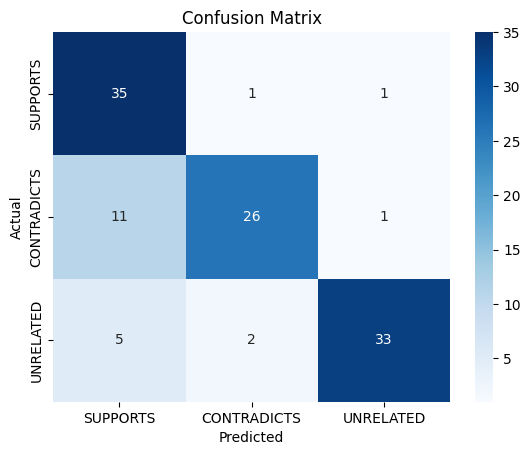

Class: SUPPORTS
Precision: 0.69
Recall: 0.95
Accuracy: 0.84
Confusion Matrix:
[[35 16]
 [ 2 59]]

Class: CONTRADICTS
Precision: 0.90
Recall: 0.68
Accuracy: 0.86
Confusion Matrix:
[[26  3]
 [12 68]]

Class: UNRELATED
Precision: 0.94
Recall: 0.82
Accuracy: 0.91
Confusion Matrix:
[[33  2]
 [ 7 61]]



In [ ]:
print("Total:  ", len(results))
print("Matches:", match_count)
print("Misses: ", miss_count)
print("Match rate:", match_count / (match_count + miss_count))
big_one(results)
# print(misses)
# print(fails)
class_metrics, confusion_matrices = calculate_metrics(results)
for cls, metrics in class_metrics.items():
    print(f'Class: {cls}')
    print(f'Precision: {metrics["precision"]:.2f}')
    print(f'Recall: {metrics["recall"]:.2f}')
    print(f'Accuracy: {metrics["accuracy"]:.2f}')
    print('Confusion Matrix:')
    print(confusion_matrices[cls])
    print()


Total:   115
Matches: 93
Misses:  22
Match rate: 0.808695652173913
[]
Class: SUPPORTS
Precision: 0.69
Recall: 0.97
Accuracy: 0.85
Confusion Matrix:
[[36 16]
 [ 1 57]]

Class: CONTRADICTS
Precision: 0.89
Recall: 0.63
Accuracy: 0.85
Confusion Matrix:
[[24  3]
 [14 69]]

Class: UNRELATED
Precision: 0.92
Recall: 0.82
Accuracy: 0.90
Confusion Matrix:
[[33  3]
 [ 7 60]]

[[36  0  1]
 [12 24  2]
 [ 4  3 33]]


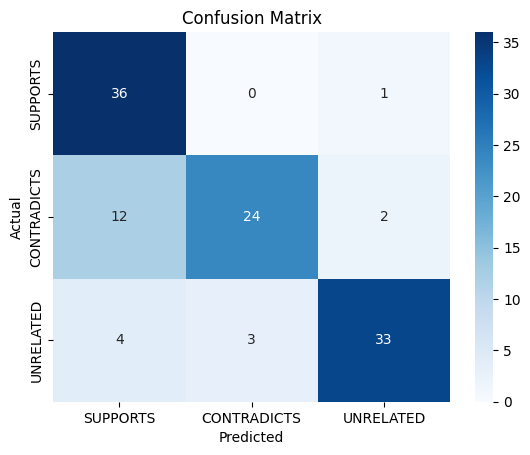

In [ ]:
# rand 22, temp 0.2, in context learning, UNRELATED

In [ ]:
# With below, UNRELATED, dev, temp 0.2, in context learning

Total:   115
Matches: 94
Misses:  21
Match rate: 0.8173913043478261
[]


Class: SUPPORTS
Precision: 0.67
Recall: 0.95
Accuracy: 0.83
Confusion Matrix:
[[35 17]
 [ 2 59]]

Class: CONTRADICTS
Precision: 0.93
Recall: 0.66
Accuracy: 0.86
Confusion Matrix:
[[25  2]
 [13 69]]

Class: UNRELATED
Precision: 0.94
Recall: 0.85
Accuracy: 0.92
Confusion Matrix:
[[34  2]
 [ 6 60]]



In [ ]:
# random 22, test not dev, unrelated not nei, 3 options, temp 0.2

Total:   107
Matches: 95
Misses:  12
Match rate: 0.8878504672897196
[('Evidence that headache of any type by itself or in association with brain lesions was not correlated with cognitive impairment was lacking.', ['OBJECTIVE To evaluate the association of overall and specific headaches with volume of white matter hyperintensities, brain infarcts, and cognition.   \n', 'DESIGN Population based, cross sectional study.   \n', 'SETTING Epidemiology of Vascular Ageing study, Nantes, France.   \n', 'PARTICIPANTS 780 participants (mean age 69, 58.5% women) with detailed headache assessment.   \n', 'MAIN OUTCOME MEASURES Brain scans were evaluated for volume of white matter hyperintensities (by fully automated imaging processing) and for classification of infarcts (by visual reading with a standardised assessment grid).', 'Cognitive function was assessed by a battery of tests including the mini-mental state examination.   \n', 'RESULTS 163 (20.9%) participants reported a history of severe head

This one is for NEI testing


In [ ]:
random.seed(22)

# p = "The following is an example of a claim and an abstract, where the abstract {} the claim. \nExample claim: {} \nExample abstract: {} \nGiven the following new abstract and claim, please state whether the abstract SUPPORTS, CONTRADICTS, or IS UNRELATED TO the claim. Please use respond using only the capitalized word(s) to provide a response. \nClaim: {} \nAbstract: {}"]
intro = "The following are examples of claims from a research paper and the corresponding abstract from the paper they are citing."
supports =  "\nThis is an example of an abstract that SUPPORTS the claim: \n\tSuppporting abstract: {} \n\tClaim: {}"
contradicts = "\nThis is an example of an abstract that CONTRADICTS the claim: \n\tContradicting abstract: {} \n\tClaim: {}"
unrelated = "\nThis is an example of an abstract that is NEI (which means there is not enough information to make an evaluation about if the abstract supports or contradicts the claim) to the claim: \n\tNEI abstract: {} \n\tClaim: {}"
query = "\nGiven a new abstract and claim pair, determine whether the abstract SUPPORTS, CONTRADICTS, or NEI to the claim. Please return your answer using only the single capitalized word. \n\tNew abstract: {} \n\tClaim: {}"

results = []
fails = []
match_count = 0
miss_count = 0
misses = []

for item in test:
  time.sleep(5.5)
  key = item['id']
  abstract = corpus[key]['abstract']
  claim = item['claim']
  label = item['label']
  query_string = query.format(abstract, claim)

  k, v = random.choice(list(train_supports.items()))
  supports_claim = v['claim']
  supports_abstract = corpus[k]['abstract']
  supports_string = supports.format(supports_abstract, supports_claim)

  k, v = random.choice(list(train_contradicts.items()))
  contradicts_claim = v['claim']
  contradicts_abstract = corpus[k]['abstract']
  contradicts_string = contradicts.format(contradicts_abstract, contradicts_claim)

  k, v = random.choice(list(train_nei.items()))
  nei_claim = v['claim']
  nei_abstract = corpus[k]['abstract']
  unrelated_string = unrelated.format(nei_abstract, nei_claim)

  temp = [supports_string, contradicts_string, unrelated_string]
  random.shuffle(temp)
  prompt = intro + temp[0] + temp[1] + temp[2] + query_string
  message = [{"role": "user", "content": prompt}]
  try:
    response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
  except:
    print('oops')

  predicted = response.choices[0].message.content
  results.append((label, predicted))

  if predicted != 'SUPPORTS' and predicted != 'CONTRADICTS' and predicted != 'NEI':
    fails.append(results[-1])
  else:
    if predicted == label:
      match_count += 1
    else:
      miss_count += 1
      misses.append((claim, abstract, label, predicted))

print("Total:  ", len(results))
print("Matches:", match_count)
print("Misses: ", miss_count)
print("Match rate:", match_count / (match_count + miss_count))
print(misses)
print(fails)

oops
Total:   115
Matches: 93
Misses:  22
Match rate: 0.808695652173913
[('No one of the most well-characterized mechanisms gained by tumor cells to antagonize the apoptotic effects of c-Myc through evolution is parallel BCL-2 activation (Letai et al., 2004; Ozdek et al., 2004) , which can blunt the c-Myc-initiated death pathway in a mitochondriadependent manner.', ['Resistance to apoptosis, often achieved by the overexpression of antiapoptotic proteins, is common and perhaps required in the genesis of cancer.', 'However, it remains uncertain whether apoptotic defects are essential for tumor maintenance.', 'To test this, we generated mice expressing a conditional BCL-2 gene and constitutive c-myc that develop lymphoblastic leukemia.', 'Eliminating BCL-2 yielded rapid loss of leukemic cells and significantly prolonged survival, formally validating BCL-2 as a rational target for cancer therapy.', 'Loss of this single molecule resulted in cell death, despite or perhaps attributable to the

In [ ]:
for miss in misses:
  print('Actual:', miss[2], '\tPredicted:', miss[3])

Actual: CONTRADICTS 	Predicted: SUPPORTS
Actual: CONTRADICTS 	Predicted: SUPPORTS
Actual: SUPPORTS 	Predicted: UNRELATED
Actual: UNRELATED 	Predicted: CONTRADICTS
Actual: CONTRADICTS 	Predicted: SUPPORTS
Actual: CONTRADICTS 	Predicted: SUPPORTS
Actual: SUPPORTS 	Predicted: UNRELATED
Actual: CONTRADICTS 	Predicted: UNRELATED
Actual: CONTRADICTS 	Predicted: SUPPORTS
Actual: CONTRADICTS 	Predicted: UNRELATED
Actual: CONTRADICTS 	Predicted: SUPPORTS
Actual: CONTRADICTS 	Predicted: SUPPORTS


Of the 12 misses, 9 were contradicts, 2 were supports, and 1 was unrelated.

Because the supports were pulled from SciFact, we assume these are 'true misses', not due to GPT errors from earlier in the pipeline (during dataset generation). Upon examination, the claims being made were extremely vague, referencing 'it' and 'those findings'. These errors are caused by the claim containing too small of a context window. Evidently, most claims fit within a single sentence; however, these missed claims reference context that might exist in the precedeing sentence or in another paragraph entirely.

The contradicts were created during the negation phase using GPT 3.5. Of the 9, supports was predicted 7 times. Of these 7, the two we checked appeared to be negation errors. We feel safe to assume as many as all 7 were negation errors.

The unrelated claim contains many of the same keywords as the abstract it is associated with. These keywords might make the model think that it is related, but that there is not enough similarity to draw a conclusion about supporting. Thus, 'contradicts' becomes something of a default label. (Our setup has created a false trio, there are more options than S, C, U. A claim could be related by no S or C. This should have beeen NEI, but we changed the wording in the prompt. U is making a call about the relationship between Claim and Abstract, NEI is deciding not to make the call.)

Evidence that headache of any type by itself or in association with brain lesions was not correlated with cognitive impairment was lacking.

Evidence that headache of any type by itself or in combination with brain lesions was associated with cognitive impairment was lacking.

In [ ]:
class_metrics, confusion_matrices = calculate_metrics(results)
for cls, metrics in class_metrics.items():
    print(f'Class: {cls}')
    print(f'Precision: {metrics["precision"]:.2f}')
    print(f'Recall: {metrics["recall"]:.2f}')
    print(f'Accuracy: {metrics["accuracy"]:.2f}')
    print('Confusion Matrix:')
    print(confusion_matrices[cls])
    print()

Class: SUPPORTS
Precision: 0.81
Recall: 0.94
Accuracy: 0.91
Confusion Matrix:
[[30  7]
 [ 2 65]]

Class: CONTRADICTS
Precision: 0.97
Recall: 0.80
Accuracy: 0.90
Confusion Matrix:
[[35  1]
 [ 9 60]]

Class: UNRELATED
Precision: 0.88
Recall: 0.97
Accuracy: 0.95
Confusion Matrix:
[[30  4]
 [ 1 65]]



Total:   107
Matches: 94
Misses:  13
Match rate: 0.8785046728971962
[]

Class: SUPPORTS
Precision: 0.79
Recall: 0.94
Accuracy: 0.90
Confusion Matrix:
[[30  8]
 [ 2 64]]

Class: CONTRADICTS
Precision: 0.97
Recall: 0.77
Accuracy: 0.90
Confusion Matrix:
[[34  1]
 [10 60]]

Class: UNRELATED
Precision: 0.88
Recall: 0.97
Accuracy: 0.95
Confusion Matrix:
[[30  4]
 [ 1 64]]



In [ ]:
# with random seed 42, randomized example ordering

Total:   107
Matches: 93
Misses:  14
Match rate: 0.8691588785046729
[]

Class: SUPPORTS
Precision: 0.76
Recall: 0.97
Accuracy: 0.89
Confusion Matrix:
[[31 10]
 [ 1 62]]

Class: CONTRADICTS
Precision: 0.94
Recall: 0.75
Accuracy: 0.88
Confusion Matrix:
[[33  2]
 [11 60]]

Class: UNRELATED
Precision: 0.94
Recall: 0.94
Accuracy: 0.96
Confusion Matrix:
[[29  2]
 [ 2 64]]



In [ ]:
# with random seed 7, randomized example ordering

Total:   107
Matches: 97
Misses:  10
Match rate: 0.9065420560747663
[]

Class: SUPPORTS
Precision: 0.82
Recall:    1.00
Accuracy:  0.93

Class: CONTRADICTS
Precision: 0.97
Recall:    0.80
Accuracy:  0.91

Class: UNRELATED
Precision: 0.94
Recall:    0.97
Accuracy:  0.97



In [ ]:
fails = []
matches = 0
misses = 0
for result in results:
  if result[1] != 'SUPPORTS' and result[1] != 'CONTRADICTS' and result[1] !='UNRELATED':
    fails.append(result)
  else:
    if result[1] == result[0]:
      matches += 1
    else:
      misses += 1
print("Total:  ", len(results))
print("Matches:", matches)
print("Misses: ", misses)
print("Match rate:", matches / (matches + misses))
print(fails)
print()
class_metrics = calculate_metrics(results)
for cls, metrics in class_metrics.items():
    print(f'Class: {cls}')
    print(f'Precision: {metrics["precision"]:.2f}')
    print(f'Recall:    {metrics["recall"]:.2f}')
    print(f'Accuracy:  {metrics["accuracy"]:.2f}')
    print()
    # Fixed with random.seed(7)

Total:   107
Matches: 95
Misses:  12
Match rate: 0.8878504672897196
[]

Class: SUPPORTS
Precision: 0.76
Recall:    0.97
Accuracy:  0.90

Class: CONTRADICTS
Precision: 0.97
Recall:    0.75
Accuracy:  0.89

Class: UNRELATED
Precision: 0.97
Recall:    1.00
Accuracy:  0.99



In [ ]:
# Fixed doc_id with random.seed(42)

Total:   107
Matches: 93
Misses:  14
Match rate: 0.8691588785046729
[]

Class: SUPPORTS
Precision: 0.74
Recall:    0.97
Accuracy:  0.89

Class: CONTRADICTS
Precision: 0.97
Recall:    0.73
Accuracy:  0.88

Class: UNRELATED
Precision: 0.94
Recall:    0.97
Accuracy:  0.97



Total:   107
Matches: 90
Misses:  17
Match rate: 0.8411214953271028
[]


In [ ]:
# Before fixing doubled doc_id issue

Total:   103
Matches: 89
Misses:  14
Match rate: 0.8640776699029126
[]


In [ ]:
for result in results: # temp = 0
  print(result)

('CONTRADICTS', 'SUPPORTS')
('UNRELATED', 'UNRELATED')
('CONTRADICTS', 'SUPPORTS')
('CONTRADICTS', 'SUPPORTS')
('CONTRADICTS', 'CONTRADICTS')
('SUPPORTS', 'SUPPORTS')
('SUPPORTS', 'SUPPORTS')
('UNRELATED', 'UNRELATED')
('SUPPORTS', 'UNRELATED')
('UNRELATED', 'UNRELATED')


In [ ]:
for result in results: # temp = 0.2
  print(result)

('CONTRADICTS', 'SUPPORTS')
('UNRELATED', 'UNRELATED')
('CONTRADICTS', 'SUPPORTS')
('CONTRADICTS', 'SUPPORTS')
('CONTRADICTS', 'CONTRADICTS')
('SUPPORTS', 'SUPPORTS')
('SUPPORTS', 'SUPPORTS')
('UNRELATED', 'UNRELATED')
('SUPPORTS', 'SUPPORTS')
('UNRELATED', 'UNRELATED')


In [ ]:
prompts = ["The following is an example of a claim and an abstract, where the abstract {} the claim. \nExample claim: {} \nExample abstract: {} \nGiven the following new abstract and claim, please state whether the abstract SUPPORTS, CONTRADICTS, or IS UNRELATED TO the claim. Please use respond using only the capitalized word(s) to provide a response. \nClaim: {} \nAbstract: {}"]
          #  "Given the following abstract of a scholarly research paper and a corresponding claim, please state whether the abstract supports, contradicts, or is unrelated to the claim. \nClaim: 'One major regulatory event includes the replacement of histone H2A with its variant H2A.Z, which destabilizes +1 nucleosomes so as to accelerate gene activation (Guillemette et al., 2005; Jin and Felsenfeld, 2007; Li et al., 2005; Meneghini et al., 2003; Zhang et al., 2005) .H2A.Z is incorporated into chromatin by SWR-C/SWR1 and is removed by INO80 (Mizuguchi et al., 2004; PapamichosChronakis et al., 2011) .' \nAbstract: 'Nucleosomes containing the histone variant H3.3 tend to be clustered in vivo in the neighborhood of transcriptionally active genes and over regulatory elements. It has not been clear, however, whether H3.3-containing nucleosomes possess unique properties that would affect transcription. We report here that H3.3 nucleosomes isolated from vertebrates, regardless of whether they are partnered with H2A or H2A.Z, are unusually sensitive to salt-dependent disruption, losing H2A/H2B or H2A.Z/H2B dimers. Immunoprecipitation studies of nucleosome core particles (NCPs) show that NCPs that contain both H3.3 and H2A.Z are even less stable than NCPs containing H3.3 and H2A. Intriguingly, NCPs containing H3 and H2A.Z are at least as stable as H3/H2A NCPs. These results establish an hierarchy of stabilities for native nucleosomes carrying different complements of variants, and suggest how H2A.Z could play different roles depending on its partners within the NCP. They also are consistent with the idea that H3.3 plays an active role in maintaining accessible chromatin structures in enhancer regions and transcribed regions. Consistent with this idea, promoters and enhancers at transcriptionally active genes and coding regions at highly expressed genes have nucleosomes that simultaneously carry both H3.3 and H2A.Z, and should therefore be extremely sensitive to disruption.' ",
          #  "Given the following abstract and claim, please state whether the abstract supports, contradicts, or is unrelated to the claim, as well as the reason why. \nClaim: 'One major regulatory event includes the replacement of histone H2A with its variant H2A.Z, which destabilizes +1 nucleosomes so as to accelerate gene activation (Guillemette et al., 2005; Jin and Felsenfeld, 2007; Li et al., 2005; Meneghini et al., 2003; Zhang et al., 2005) .H2A.Z is incorporated into chromatin by SWR-C/SWR1 and is removed by INO80 (Mizuguchi et al., 2004; PapamichosChronakis et al., 2011) .' \nAbstract: 'Nucleosomes containing the histone variant H3.3 tend to be clustered in vivo in the neighborhood of transcriptionally active genes and over regulatory elements. It has not been clear, however, whether H3.3-containing nucleosomes possess unique properties that would affect transcription. We report here that H3.3 nucleosomes isolated from vertebrates, regardless of whether they are partnered with H2A or H2A.Z, are unusually sensitive to salt-dependent disruption, losing H2A/H2B or H2A.Z/H2B dimers. Immunoprecipitation studies of nucleosome core particles (NCPs) show that NCPs that contain both H3.3 and H2A.Z are even less stable than NCPs containing H3.3 and H2A. Intriguingly, NCPs containing H3 and H2A.Z are at least as stable as H3/H2A NCPs. These results establish an hierarchy of stabilities for native nucleosomes carrying different complements of variants, and suggest how H2A.Z could play different roles depending on its partners within the NCP. They also are consistent with the idea that H3.3 plays an active role in maintaining accessible chromatin structures in enhancer regions and transcribed regions. Consistent with this idea, promoters and enhancers at transcriptionally active genes and coding regions at highly expressed genes have nucleosomes that simultaneously carry both H3.3 and H2A.Z, and should therefore be extremely sensitive to disruption.'",
          #  "Given the following abstract of a scholarly research paper and a corresponding claim, please state whether the abstract supports, contradicts, or is unrelated to the claim, as well as the reason why. \nClaim: 'One major regulatory event includes the replacement of histone H2A with its variant H2A.Z, which destabilizes +1 nucleosomes so as to accelerate gene activation (Guillemette et al., 2005; Jin and Felsenfeld, 2007; Li et al., 2005; Meneghini et al., 2003; Zhang et al., 2005) .H2A.Z is incorporated into chromatin by SWR-C/SWR1 and is removed by INO80 (Mizuguchi et al., 2004; PapamichosChronakis et al., 2011) .' \nAbstract: 'Nucleosomes containing the histone variant H3.3 tend to be clustered in vivo in the neighborhood of transcriptionally active genes and over regulatory elements. It has not been clear, however, whether H3.3-containing nucleosomes possess unique properties that would affect transcription. We report here that H3.3 nucleosomes isolated from vertebrates, regardless of whether they are partnered with H2A or H2A.Z, are unusually sensitive to salt-dependent disruption, losing H2A/H2B or H2A.Z/H2B dimers. Immunoprecipitation studies of nucleosome core particles (NCPs) show that NCPs that contain both H3.3 and H2A.Z are even less stable than NCPs containing H3.3 and H2A. Intriguingly, NCPs containing H3 and H2A.Z are at least as stable as H3/H2A NCPs. These results establish an hierarchy of stabilities for native nucleosomes carrying different complements of variants, and suggest how H2A.Z could play different roles depending on its partners within the NCP. They also are consistent with the idea that H3.3 plays an active role in maintaining accessible chromatin structures in enhancer regions and transcribed regions. Consistent with this idea, promoters and enhancers at transcriptionally active genes and coding regions at highly expressed genes have nucleosomes that simultaneously carry both H3.3 and H2A.Z, and should therefore be extremely sensitive to disruption.' "]
results = []
flag = 0
for key in test.keys():
  time.sleep(10)
  flag += 1
  abstract = corpus[key]['abstract']
  claim = test[key]['claim']
  label = test[key]['label']
  k, v = random.choice(list(train.items()))
  example_claim = v['claim']
  example_abstract = corpus[k]['abstract']
  example_label = v['label']
  for p in prompts:
    prompt = p.format(example_label, example_claim, example_abstract, claim, abstract)
    message = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(model="gpt-4", messages=message, temperature=0.2)
    results.append((label, response.choices[0].message.content))
  # if flag == 10:
  #   break

In [ ]:
fails = []
matches = 0
misses = 0
for result in results:
  if result[1] != 'SUPPORTS' and result[1] != 'CONTRADICTS' and 'UNRELATED' not in result[1]:
    fails.append(result)
  else:
    if result[1] == result[0] or 'UNRELATED' in result[1] and 'UNRELATED' in result[0]:
      matches += 1
    else:
      misses += 1
print("Total:  ", len(results))
print("Matches:", matches)
print("Misses: ", misses)
print("Match rate:", matches / (matches + misses))
print(fails)
# One rand

Total:   103
Matches: 75
Misses:  28
Match rate: 0.7281553398058253
[]


In [ ]:
for result in results:
  if 'UNRELATED' in result[1]:
    print(result)

('IS UNRELATED TO', 'UNRELATED')
('IS UNRELATED TO', 'UNRELATED')
('IS UNRELATED TO', 'IS UNRELATED TO')
('IS UNRELATED TO', 'UNRELATED')
('IS UNRELATED TO', 'UNRELATED')
('IS UNRELATED TO', 'IS UNRELATED TO')
('IS UNRELATED TO', 'IS UNRELATED TO')
('IS UNRELATED TO', 'UNRELATED')
('CONTRADICTS', 'IS UNRELATED TO')
('IS UNRELATED TO', 'IS UNRELATED TO')
('IS UNRELATED TO', 'UNRELATED')
('IS UNRELATED TO', 'UNRELATED')
('CONTRADICTS', 'UNRELATED')
('IS UNRELATED TO', 'UNRELATED')
('IS UNRELATED TO', 'UNRELATED')
('IS UNRELATED TO', 'IS UNRELATED TO')
('IS UNRELATED TO', 'IS UNRELATED TO')
('IS UNRELATED TO', 'UNRELATED')
('IS UNRELATED TO', 'UNRELATED')
('IS UNRELATED TO', 'UNRELATED')
('IS UNRELATED TO', 'IS UNRELATED TO')
('IS UNRELATED TO', 'UNRELATED')
('IS UNRELATED TO', 'UNRELATED')
('IS UNRELATED TO', 'UNRELATED')
('IS UNRELATED TO', 'IS UNRELATED TO')
('IS UNRELATED TO', 'IS UNRELATED TO')
('IS UNRELATED TO', 'IS UNRELATED TO')
('IS UNRELATED TO', 'UNRELATED')
('IS UNRELATED TO'

In [ ]:
for result in results: # temp = 0, random in context learning from train, first 10
  print(result)

('CONTRADICTS', 'SUPPORTS')
('IS UNRELATED TO', 'UNRELATED')
('CONTRADICTS', 'SUPPORTS')
('CONTRADICTS', 'SUPPORTS')
('CONTRADICTS', 'SUPPORTS')
('SUPPORTS', 'SUPPORTS')
('SUPPORTS', 'SUPPORTS')
('IS UNRELATED TO', 'UNRELATED')
('SUPPORTS', 'SUPPORTS')
('IS UNRELATED TO', 'SUPPORTS')


In [ ]:
for result in results: # temp = 0.2, random in context learning from train, first 10
  print(result)

('CONTRADICTS', 'SUPPORTS')
('IS UNRELATED TO', 'IS UNRELATED TO')
('CONTRADICTS', 'SUPPORTS')
('CONTRADICTS', 'SUPPORTS')
('CONTRADICTS', 'SUPPORTS')
('SUPPORTS', 'SUPPORTS')
('SUPPORTS', 'SUPPORTS')
('IS UNRELATED TO', 'IS UNRELATED TO')
('SUPPORTS', 'SUPPORTS')
('IS UNRELATED TO', 'SUPPORTS')


In [ ]:
for result in results: # temp = 0.2, random in context learning from train
  print(result)

('CONTRADICTS', 'SUPPORTS')
('IS UNRELATED TO', 'IS UNRELATED TO')
('CONTRADICTS', 'SUPPORTS')
('CONTRADICTS', 'SUPPORTS')
('CONTRADICTS', 'SUPPORTS')


In [ ]:
for result in results: # temp = 0.2, shortened output
  print(result)

('CONTRADICT', 'SUPPORTS')
('NEI', 'UNRELATED')
('CONTRADICT', 'SUPPORTS')
('CONTRADICT', 'SUPPORTS')
('CONTRADICT', 'SUPPORTS')


In [ ]:
for result in results: # temp = 0.2
  print(result)

('CONTRADICT', 'The abstract supports the claim. The abstract states that "Evidence was lacking for cognitive impairment for any headache type with or without brain lesions." This supports the claim that evidence was lacking for a correlation between headaches (of any type, and in association with brain lesions) and cognitive impairment.')
('NEI', 'The abstract is unrelated to the claim. The claim discusses the correlation between headaches and cognitive impairment, while the abstract discusses the relationship between migraines and white matter lesions. Cognitive impairment is not mentioned in the abstract.')
('CONTRADICT', 'Supports')
('CONTRADICT', 'The abstract supports the claim. The abstract states that a combination including oxaliplatin was preferable to single-agent fluoropyrimidines, which aligns with the claim that treatment with single agent fluoropyrimidines resulted in similar efficacy outcomes but worse quality of life, as compared with combination oxaliplatin-based chem

In [ ]:
for result in results: # temp = 0
  print(result)

('CONTRADICT', 'The abstract supports the claim. It states that "Evidence was lacking for cognitive impairment for any headache type with or without brain lesions." This aligns with the claim that there was no evidence of a correlation between headaches (of any type, alone or in association with brain lesions) and cognitive impairment.')
('NEI', 'The abstract is unrelated to the claim. The claim discusses the correlation between headaches and cognitive impairment, while the abstract discusses the potential causes and implications of white matter lesions in migraine sufferers.')
('CONTRADICT', 'The abstract supports the claim. It states that enhancing cSMAC formation reduced the stimulatory capacity of the weak peptide, which aligns with the claim that cSMAC formation could not enhance signaling by weak ligands.')
('CONTRADICT', 'The abstract supports the claim. The claim states that a randomized clinical trial showed that treatment with single agent fluoropyrimidines resulted in simila

# Claim to evidence scoring

In [ ]:
rouge = claim_to_evidence('SBERT')
print("SBERT Total: " + str(len(rouge)))
s = len([x[0] for x in rouge if x[1] == 'SUPPORT'])
c = len([x[0] for x in rouge if x[1] == 'CONTRADICT'])
print("Support total:      " + str(s))
print("Contradict total:   " + str(c))
print("Support average:    " + str(sum([x[0] for x in rouge if x[1] == 'SUPPORT']) / s))
print("Contradict average: " + str(sum([x[0] for x in rouge if x[1] == 'CONTRADICT']) / c))

SBERT Total: 1295
Support total:    832
Contradict total: 463
Support total:    0.666876542274482
Contradict total: 0.5695267268345886


In [ ]:
rouge = claim_to_evidence('IMS')
print("IMS Total: " + str(len(rouge)))
s = len([x[0] for x in rouge if x[1] == 'SUPPORT'])
c = len([x[0] for x in rouge if x[1] == 'CONTRADICT'])
print("Support total:      " + str(s))
print("Contradict total:   " + str(c))
print("Support average:    " + str(sum([x[0] for x in rouge if x[1] == 'SUPPORT']) / s))
print("Contradict average: " + str(sum([x[0] for x in rouge if x[1] == 'CONTRADICT']) / c))

IMS Total: 1295
Support total:    832
Contradict total: 463
Support total:    0.6480768732601205
Contradict total: 0.5997392144528886


In [ ]:
rouge = claim_to_evidence('ROUGE')
print("ROUGE Total: " + str(len(rouge)))
s = len([x[0] for x in rouge if x[1] == 'SUPPORT'])
c = len([x[0] for x in rouge if x[1] == 'CONTRADICT'])
print("Support total:      " + str(s))
print("Contradict total:   " + str(c))
print("Support average:    " + str(sum([x[0] for x in rouge if x[1] == 'SUPPORT']) / s))
print("Contradict average: " + str(sum([x[0] for x in rouge if x[1] == 'CONTRADICT']) / c))

ROUGE Total: 1295
Support total:      832
Contradict total:   463
Support average:    0.1611613250297069
Contradict average: 0.1410063928341911


In [ ]:
rouge = claim_to_evidence('BLEU')
print("BLEU Total: " + str(len(rouge)))
s = len([x[0] for x in rouge if x[1] == 'SUPPORT'])
c = len([x[0] for x in rouge if x[1] == 'CONTRADICT'])
print("Support total:      " + str(s))
print("Contradict total:   " + str(c))
print("Support average:    " + str(sum([x[0] for x in rouge if x[1] == 'SUPPORT']) / s))
print("Contradict average: " + str(sum([x[0] for x in rouge if x[1] == 'CONTRADICT']) / c))

BLEU Total: 1295
Support total:    832
Contradict total: 463
Support total:    3.1331482441475366e-232
Contradict total: 2.6963268756556605e-232


# Citance to evidence scoring

In [ ]:
failed_claims = []
for key in claims_and_evidence:
    failed_claims.append(key)
# Claim to evidence (SciFact dataset)
for claim in sorted(failed_claims):
    print(claim)

In [ ]:
# Citance to claims (claim generation)
for key in sorted(failed_keys):
    print(key)

ROUGE for citance to evidence:
Average of average: 0.19197059725811183
Average of max:     0.2197786799728223
Max of max:         0.8278388278388279
Q1 quantile:  0.12280701754385964
Q2 quantile:  0.15798408388635152
Q3 quantile:  0.22291128337639965
Q4 quantile:  0.8278388278388279
ROUGE for claim to evidence:
Average of average: 0.1539553531327773
Q1 quantile:  0.07936507936507936
Q2 quantile:  0.12923076923076923
Q3 quantile:  0.20807235807235808
Q4 quantile:  0.958840579710145


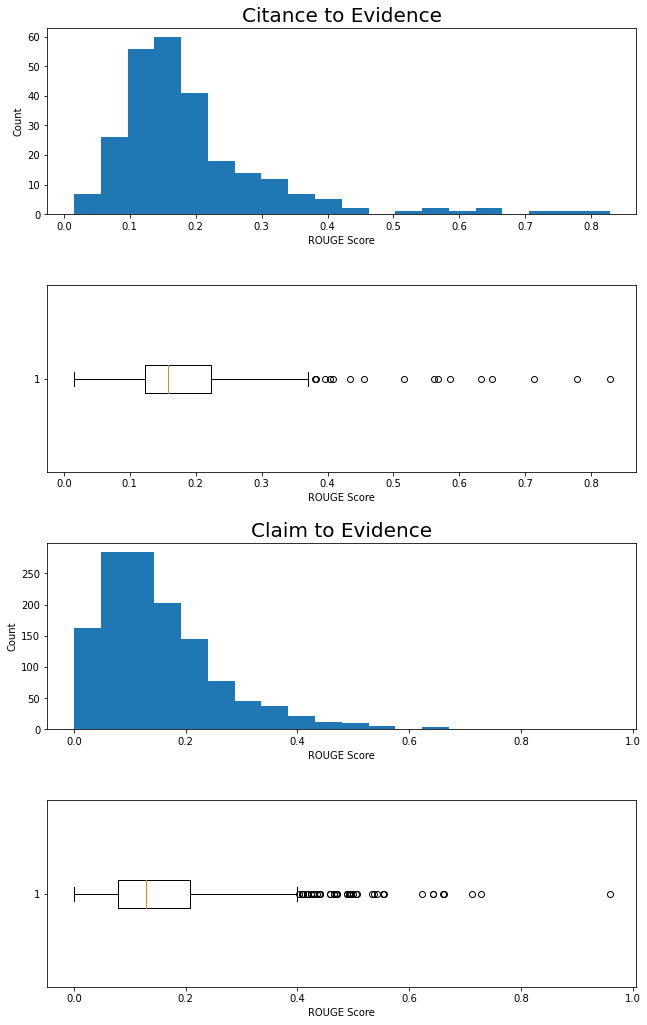

In [ ]:
hist_and_box_plot("ROUGE")

Total: 737
Failure rate: 0.6512890094979648
Failed total:  480
Success total: 257
SBERT for citance to evidence:
Average of average: 0.7034826610284904
Average of max:     0.737726395464129
Max of max:         0.9496700763702393
Q1 quantile:  0.6412240266799927
Q2 quantile:  0.7197386423746744
Q3 quantile:  0.7704775929450989
Q4 quantile:  0.9496700763702393
SBERT for claim to evidence:
Average of average: 0.6320711642446205
Q1 quantile:  0.5329437255859375
Q2 quantile:  0.6546671390533447
Q3 quantile:  0.7375625371932983
Q4 quantile:  0.9491794109344482


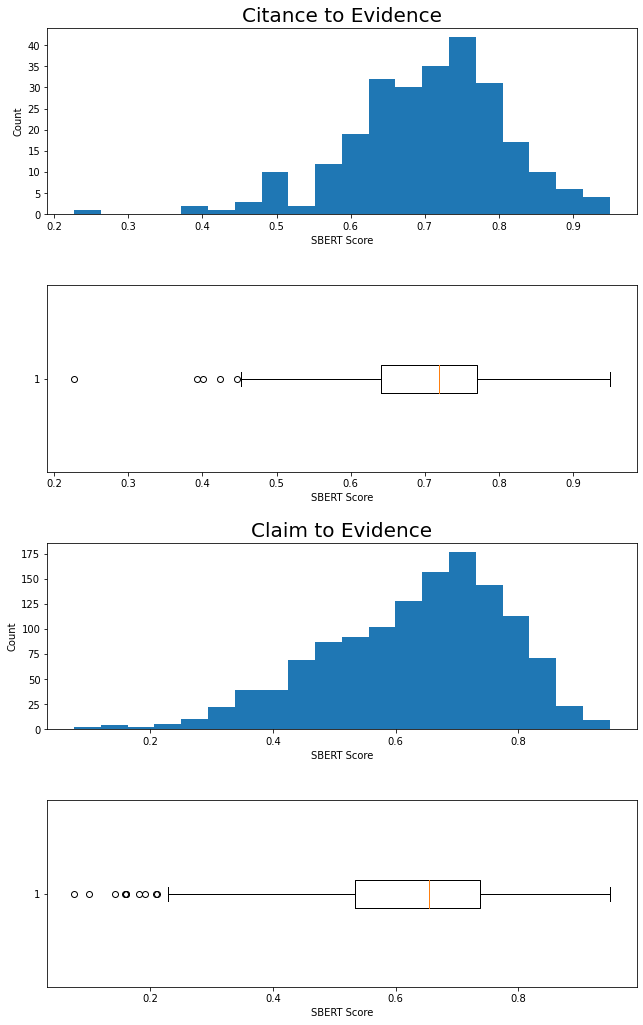

In [ ]:
hist_and_box_plot("SBERT")

IMS for citance to evidence:
Average of average: 0.6450663448257524
Average of max:     0.6817879285793828
Max of max:         0.9657854557037353
Q1 quantile:  0.5621825456619263
Q2 quantile:  0.6512966156005859
Q3 quantile:  0.7307201623916626
Q4 quantile:  0.9657854557037353
IMS for claim to evidence:
Average of average: 0.6307947469048172
Q1 quantile:  0.5337943792343139
Q2 quantile:  0.6426920890808105
Q3 quantile:  0.735196876525879
Q4 quantile:  0.9743554592132568


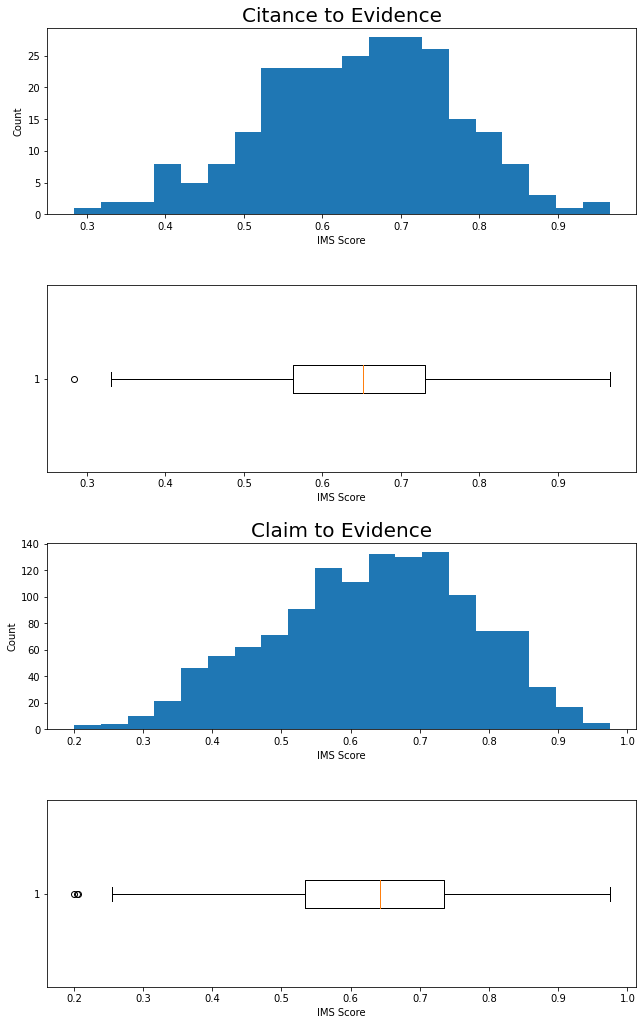

In [ ]:
hist_and_box_plot("IMS")

In [ ]:
# CARLOS' Unnecessary Code Block
citance_to_id_dict = {}
with open(f'/content/gdrive/MyDrive/Independent study - Max & Carlos/scifact_dataset/claims_with_citances.jsonl') as f_pdf:
    for line in f_pdf:
        citance_dict = json.loads(line)
        citance_to_id_dict[citance_dict['citance']] = citance_dict['s2orc_id']